# US Power Outages Analysis

**Name(s)**: David Lisbonne

**Website Link**: https://djlisbonne.github.io/power_outage_analysis/

In [12]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from tabulate import tabulate
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from lec_utils import * # Feel free to uncomment and use this. It'll make your plotly graphs look like ours in lecture!

/var/folders/3r/h9skfdh12kg2nztqjg7tdhj80000gn/T/ipykernel_28515/3176251559.py:5: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



## Step 1: Introduction

In this project, I investigate a comprehensive dataset published by Purdue University that catalogued power outages across the United States, along with a suite of external variables recorded for each outage. These additional features include geographical location of the outages, regional climate classifications, land-use characteristics, electricity consumption patterns and economic characteristics of the states affected by the outages. 

Initially, I needed to clean the data and perform an initial foray into analyzing the dataset. It contains over 1500 rows, with some more niche columns –– for example, HURRICANE_NAME –– being largely null. As a result, I first needed to sanitize, organize and normalize the dataset. 

Then, I explored a univariate analysis, focusing on three different variables in three different studies. These were: THREE VARIABLES. My hypotheses for these three variables were as follows: HYPOTHESES.

Next, I wanted to dive deeper into a bivariate analysis, leveraging combined and related features to better understand patterns in the dataset, and thus build a better predictive model. 

## Step 2: Data Cleaning and Exploratory Data Analysis

In [13]:
# first, need to import data and re-factor the excel dataset to be properly represented in a DataFrame
def import_data():
    df = pd.read_excel('outage.xlsx', skiprows=4)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df = df.reset_index(drop=True)
    units = df.iloc[0].dropna().to_dict()
    df = df.drop(0)

    return units, df

In [14]:
def clean_impute(df):
    df_cleaned = df.copy()
    # Impute missing values for numerical features
    numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
    df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].mean())
    
    # Impute missing values for categorical features
    categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
    df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna(df_cleaned[categorical_columns].mode().iloc[0])
    
    # Check if there are any missing values left
    # print("\nMissing values after cleaning:")
    # print(df_cleaned.isnull().sum())

    # Custom imputation scheme for columns of interest
    df['QUARTER'] = df['MONTH'].apply(lambda x: (x - 1) // 3 + 1)

    # Calculate the most common CAUSE.CATEGORY.DETAIL for each POSTAL.CODE and QUARTER combination
    common_details = df.groupby(['POSTAL.CODE', 'QUARTER'])['CAUSE.CATEGORY.DETAIL'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
    
    # Merge this common_details back with the original DataFrame to use for imputation
    df = df.merge(common_details, on=['POSTAL.CODE', 'QUARTER'], how='left', suffixes=('', '_IMPUTED'))
    
    # Impute missing values in "CAUSE.CATEGORY.DETAIL" with the most common value from the same postal code and quarter
    df['CAUSE.CATEGORY.DETAIL'] = df['CAUSE.CATEGORY.DETAIL'].fillna(df['CAUSE.CATEGORY.DETAIL_IMPUTED'])
    
    # Drop the temporary imputed column
    df = df.drop(columns=['CAUSE.CATEGORY.DETAIL_IMPUTED'])

    return df_cleaned

In [15]:
units, df = import_data()

In [16]:
df = clean_impute(df)
df = df.drop(df.columns[0], axis=1)
df[['MONTH', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'RES.CUST.PCT', 'CAUSE.CATEGORY']].head()

,MONTH,ANOMALY.LEVEL,CLIMATE.CATEGORY,RES.CUST.PCT,CAUSE.CATEGORY
1,7,-0.3,normal,88.944776,severe weather
2,5,-0.1,normal,88.833534,intentional attack
3,10,-1.5,cold,88.920583,severe weather
4,6,-0.1,normal,88.895368,severe weather
5,7,1.2,warm,88.821637,severe weather


In [17]:
md_cleaned = df[['MONTH', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'RES.CUST.PCT', 'CAUSE.CATEGORY']].head().to_markdown()
with open('assets/cleaned_head.md', 'w') as f:
    f.write(md_cleaned)

In [18]:
# Create a pivot table to summarize the data
pivot_table = df.pivot_table(
    values='OUTAGE.DURATION',    # Target variable: Average Outage Duration
    index=['U.S._STATE', 'CAUSE.CATEGORY'],  # Group by these columns
    aggfunc='mean',  # We are interested in the average outage duration
    fill_value=0  # Fill missing values with 0 if there are any
)

# Display the pivot table
html_output = pivot_table.to_html()
md_output = pivot_table.to_markdown()

with open('assets/pivot_table.md', 'w') as f:
    f.write(md_output)
    
# display(HTML(html_output))(pivot_table)
from IPython.display import display, Markdown
display(Markdown(md_output))

|                                                     |   OUTAGE.DURATION |
|:----------------------------------------------------|------------------:|
| ('Alabama', 'intentional attack')                   |         77        |
| ('Alabama', 'severe weather')                       |       1137.6      |
| ('Alaska', 'equipment failure')                     |          1        |
| ('Arizona', 'equipment failure')                    |        138.5      |
| ('Arizona', 'intentional attack')                   |        533.167    |
| ('Arizona', 'severe weather')                       |      25726.5      |
| ('Arizona', 'system operability disruption')        |        384.5      |
| ('Arkansas', 'equipment failure')                   |        105        |
| ('Arkansas', 'intentional attack')                  |        547.833    |
| ('Arkansas', 'islanding')                           |          3        |
| ('Arkansas', 'public appeal')                       |       1063.71     |
| ('Arkansas', 'severe weather')                      |       2701.8      |
| ('California', 'equipment failure')                 |        524.81     |
| ('California', 'fuel supply emergency')             |       3620.76     |
| ('California', 'intentional attack')                |        946.458    |
| ('California', 'islanding')                         |        214.857    |
| ('California', 'public appeal')                     |       2028.11     |
| ('California', 'severe weather')                    |       2802.91     |
| ('California', 'system operability disruption')     |        345.976    |
| ('Colorado', 'fuel supply emergency')               |          1        |
| ('Colorado', 'intentional attack')                  |        117        |
| ('Colorado', 'islanding')                           |          2        |
| ('Colorado', 'severe weather')                      |       2727.25     |
| ('Colorado', 'system operability disruption')       |        279.75     |
| ('Connecticut', 'intentional attack')               |         49.125    |
| ('Connecticut', 'severe weather')                   |       2262.6      |
| ('Delaware', 'equipment failure')                   |         50        |
| ('Delaware', 'intentional attack')                  |         38.9189   |
| ('Delaware', 'severe weather')                      |       2153.5      |
| ('Delaware', 'system operability disruption')       |          1        |
| ('District of Columbia', 'equipment failure')       |        159        |
| ('District of Columbia', 'severe weather')          |       4764.11     |
| ('Florida', 'equipment failure')                    |        554.5      |
| ('Florida', 'intentional attack')                   |         50        |
| ('Florida', 'public appeal')                        |       4320        |
| ('Florida', 'severe weather')                       |       6420.19     |
| ('Florida', 'system operability disruption')        |        205.7      |
| ('Georgia', 'intentional attack')                   |        108        |
| ('Georgia', 'severe weather')                       |       1422.75     |
| ('Hawaii', 'severe weather')                        |        997.5      |
| ('Hawaii', 'system operability disruption')         |        237        |
| ('Idaho', 'intentional attack')                     |        246.2      |
| ('Idaho', 'public appeal')                          |       1548        |
| ('Idaho', 'system operability disruption')          |        179.667    |
| ('Illinois', 'equipment failure')                   |        149        |
| ('Illinois', 'fuel supply emergency')               |       2761        |
| ('Illinois', 'intentional attack')                  |       1450        |
| ('Illinois', 'public appeal')                       |        120        |
| ('Illinois', 'severe weather')                      |       1572.14     |
| ('Indiana', 'equipment failure')                    |          1        |
| ('Indiana', 'fuel supply emergency')                |      12240        |
| ('Indiana', 'intentional attack')                   |        421.875    |
| ('Indiana', 'islanding')                            |        125.333    |
| ('Indiana', 'severe weather')                       |       4523.29     |
| ('Indiana', 'system operability disruption')        |       4671.6      |
| ('Iowa', 'intentional attack')                      |       5657.8      |
| ('Iowa', 'severe weather')                          |       3353.67     |
| ('Kansas', 'intentional attack')                    |        561        |
| ('Kansas', 'public appeal')                         |        913        |
| ('Kansas', 'severe weather')                        |       5608        |
| ('Kentucky', 'equipment failure')                   |        652        |
| ('Kentucky', 'fuel supply emergency')               |      12570        |
| ('Kentucky', 'intentional attack')                  |        108        |
| ('Kentucky', 'severe weather')                      |       4480.11     |
| ('Louisiana', 'equipment failure')                  |        176.333    |
| ('Louisiana', 'fuel supply emergency')              |      28170        |
| ('Louisiana', 'public appeal')                      |       1359.21     |
| ('Louisiana', 'severe weather')                     |       6288.69     |
| ('Louisiana', 'system operability disruption')      |       1144.67     |
| ('Maine', 'fuel supply emergency')                  |       1676        |
| ('Maine', 'intentional attack')                     |         71        |
| ('Maine', 'islanding')                              |        881        |
| ('Maine', 'severe weather')                         |       1669.4      |
| ('Maryland', 'intentional attack')                  |        225.32     |
| ('Maryland', 'severe weather')                      |       4006.94     |
| ('Maryland', 'system operability disruption')       |        304        |
| ('Massachusetts', 'fuel supply emergency')          |       2891        |
| ('Massachusetts', 'intentional attack')             |        384.25     |
| ('Massachusetts', 'severe weather')                 |       1556.57     |
| ('Massachusetts', 'system operability disruption')  |         67        |
| ('Michigan', 'equipment failure')                   |      26435.3      |
| ('Michigan', 'intentional attack')                  |       3635.25     |
| ('Michigan', 'islanding')                           |          1        |
| ('Michigan', 'public appeal')                       |       1078        |
| ('Michigan', 'severe weather')                      |       4831.65     |
| ('Michigan', 'system operability disruption')       |       2610        |
| ('Minnesota', 'intentional attack')                 |        369.5      |
| ('Minnesota', 'severe weather')                     |       3585.55     |
| ('Mississippi', 'intentional attack')               |         12        |
| ('Mississippi', 'system operability disruption')    |        300        |
| ('Missouri', 'intentional attack')                  |        245.2      |
| ('Missouri', 'severe weather')                      |       4483.82     |
| ('Missouri', 'system operability disruption')       |         65        |
| ('Montana', 'intentional attack')                   |         93        |
| ('Montana', 'islanding')                            |         34.5      |
| ('Nebraska', 'public appeal')                       |        159        |
| ('Nebraska', 'severe weather')                      |       3221.33     |
| ('Nevada', 'intentional attack')                    |        553.286    |
| ('New Hampshire', 'intentional attack')             |         60        |
| ('New Hampshire', 'severe weather')                 |       1597.5      |
| ('New Jersey', 'intentional attack')                |         73.1      |
| ('New Jersey', 'severe weather')                    |       6095.83     |
| ('New Jersey', 'system operability disruption')     |        748.5      |
| ('New Mexico', 'fuel supply emergency')             |         76        |
| ('New Mexico', 'intentional attack')                |        174.5      |
| ('New Mexico', 'system operability disruption')     |          0        |
| ('New York', 'equipment failure')                   |        247        |
| ('New York', 'fuel supply emergency')               |      16687.2      |
| ('New York', 'intentional attack')                  |        285.385    |
| ('New York', 'public appeal')                       |       2655        |
| ('New York', 'severe weather')                      |       6034.58     |
| ('New York', 'system operability disruption')       |       1176.57     |
| ('North Carolina', 'intentional attack')            |       1063.75     |
| ('North Carolina', 'severe weather')                |       1682.87     |
| ('North Carolina', 'system operability disruption') |         82.2      |
| ('North Dakota', 'fuel supply emergency')           |          1        |
| ('North Dakota', 'public appeal')                   |        720        |
| ('Ohio', 'equipment failure')                       |          1        |
| ('Ohio', 'intentional attack')                      |        327.286    |
| ('Ohio', 'severe weather')                          |       4322.27     |
| ('Ohio', 'system operability disruption')           |       1744.5      |
| ('Oklahoma', 'intentional attack')                  |         75.6667   |
| ('Oklahoma', 'islanding')                           |        984        |
| ('Oklahoma', 'public appeal')                       |        704        |
| ('Oklahoma', 'severe weather')                      |       3711.71     |
| ('Oregon', 'equipment failure')                     |        200        |
| ('Oregon', 'intentional attack')                    |        374.45     |
| ('Oregon', 'severe weather')                        |       2295.8      |
| ('Pennsylvania', 'equipment failure')               |        376        |
| ('Pennsylvania', 'intentional attack')              |       1526.83     |
| ('Pennsylvania', 'severe weather')                  |       4314        |
| ('Pennsylvania', 'system operability disruption')   |        329        |
| ('South Carolina', 'severe weather')                |       3135        |
| ('South Dakota', 'islanding')                       |        120        |
| ('Tennessee', 'equipment failure')                  |        404        |
| ('Tennessee', 'intentional attack')                 |        128.5      |
| ('Tennessee', 'public appeal')                      |       2700        |
| ('Tennessee', 'severe weather')                     |       1386.35     |
| ('Tennessee', 'system operability disruption')      |         13.6667   |
| ('Texas', 'equipment failure')                      |        338.167    |
| ('Texas', 'fuel supply emergency')                  |       6960.5      |
| ('Texas', 'intentional attack')                     |        298.769    |
| ('Texas', 'public appeal')                          |       1140.41     |
| ('Texas', 'severe weather')                         |       3795.6      |
| ('Texas', 'system operability disruption')          |        810.8      |
| ('Utah', 'equipment failure')                       |         15        |
| ('Utah', 'intentional attack')                      |        142.286    |
| ('Utah', 'public appeal')                           |       2275        |
| ('Utah', 'severe weather')                          |        957        |
| ('Utah', 'system operability disruption')           |        537.5      |
| ('Vermont', 'intentional attack')                   |         35.4444   |
| ('Virginia', 'equipment failure')                   |          1        |
| ('Virginia', 'intentional attack')                  |          2        |
| ('Virginia', 'public appeal')                       |        683.5      |
| ('Virginia', 'severe weather')                      |       1132.28     |
| ('Virginia', 'system operability disruption')       |        241        |
| ('Washington', 'equipment failure')                 |       1204        |
| ('Washington', 'fuel supply emergency')             |          1        |
| ('Washington', 'intentional attack')                |        360.281    |
| ('Washington', 'islanding')                         |         44.4      |
| ('Washington', 'public appeal')                     |        248        |
| ('Washington', 'severe weather')                    |       4561.46     |
| ('Washington', 'system operability disruption')     |         25        |
| ('West Virginia', 'intentional attack')             |          1        |
| ('West Virginia', 'severe weather')                 |       9305        |
| ('Wisconsin', 'fuel supply emergency')              |      27177.2      |
| ('Wisconsin', 'intentional attack')                 |        459        |
| ('Wisconsin', 'public appeal')                      |        388        |
| ('Wisconsin', 'severe weather')                     |       1527.43     |
| ('Wyoming', 'equipment failure')                    |         61        |
| ('Wyoming', 'intentional attack')                   |          0.333333 |
| ('Wyoming', 'islanding')                            |         32        |
| ('Wyoming', 'severe weather')                       |        106        |

In [19]:
print(f"anomaly range: [{df['ANOMALY.LEVEL'].min()}, {df['ANOMALY.LEVEL'].max()}]")

anomaly range: [-1.6, 2.3]


## Univariate Analysis

### Analysis 1) Distribution of Cause Category

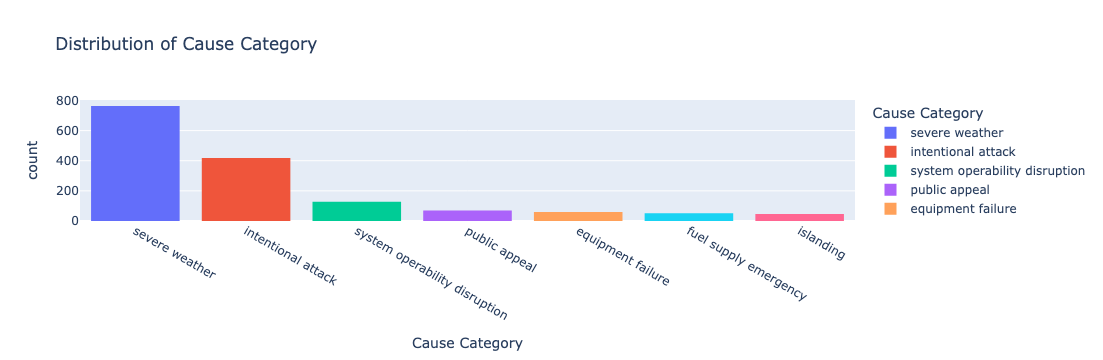

In [20]:
# Create the distribution plot using Plotly Express
fig = px.histogram(df, x='CAUSE.CATEGORY', 
                   title='Distribution of Cause Category', 
                   labels={'CAUSE.CATEGORY': 'Cause Category'}, 
                   color='CAUSE.CATEGORY', 
                   category_orders={'CAUSE.CATEGORY': df['CAUSE.CATEGORY'].value_counts().index.tolist()},
)

# Show the figure
fig.show()

fig.write_html('uni_dist.html', include_plotlyjs='cdn')

## Bivariate Anaylsis

### Analysis 1) Outage Start Time vs. Outage Duration

In [21]:
outage_start_time = df["OUTAGE.START.TIME"]
outage_duration = df["OUTAGE.DURATION"]

In [22]:
df_extracted = df_interest[['OUTAGE.START.TIME', 'OUTAGE.DURATION']]
df_extracted['OUTAGE.DURATION'] = df_extracted['OUTAGE.DURATION']
df_sorted = df_extracted.sort_values(by='OUTAGE.START.TIME')
labels = {
    'title': 'Relationship between OUTAGE.START.TIME and OUTAGE.DURATION',
    'xtitle': 'Outage Start Time',
    'ytitle': 'Outage Duration (mins)'
}
f1 = gen_uni_scatter(df_sorted['OUTAGE.START.TIME'], df_sorted['OUTAGE.DURATION'], labels)

f1.show()
f1.write_html('fig1.html', include_plotlyjs='cdn')

NameError: name 'df_interest' is not defined

### Analysis 2) Outage Month vs Outage Duration

In [23]:
df2 = df_interest[['OUTAGE.START.DATE', 'OUTAGE.DURATION']]
df2['OUTAGE.MONTH'] = pd.to_datetime(df2['OUTAGE.START.DATE']).dt.month
labels = {
    'title': 'Relationship between OUTAGE.MONTH and OUTAGE.DURATION',
    'xtitle': 'Outage Month',
    'ytitle': 'Outage Duration (mins)',
    'xaxis': dict(dtick=1)
}

f2 = gen_uni_scatter(df2['OUTAGE.MONTH'], df2['OUTAGE.DURATION'], labels)
f2.show()
f2.write_html('fig2.html', include_plotlyjs='cdn')

NameError: name 'df_interest' is not defined

### Analysis 3) Outage Cause Category vs Outage Duration

In [24]:
df3 = df_interest[['CAUSE.CATEGORY', 'OUTAGE.DURATION']]
average_outage_duration = df3.groupby('CAUSE.CATEGORY')['OUTAGE.DURATION'].median().sort_values(ascending=False)
print(f"AVG.DURATION by CAUSE.CATEGORY: {average_outage_duration}")
labels = {
    'title': 'Relationship between Outage Cause Category and Outage Duration',
     'xtitle': 'Outage Cause Category',
     'ytitle': 'Outage Duration (mins)',
     }
f3 = gen_uni_scatter(df3['CAUSE.CATEGORY'], df3['OUTAGE.DURATION'], labels)
f3.show()
f3.write_html('fig3.html', include_plotlyjs='cdn')

NameError: name 'df_interest' is not defined

In [25]:
fig = go.Figure(data=[
    go.Bar(
        x=average_outage_duration.index,  
        y=average_outage_duration.values,
        marker=dict(color='blue')  # Set the color of the bars
    )
])

# Customize layout
fig.update_layout(
    title='Median Outage Duration by Cause Category',
    xaxis_title='Cause Category',
    yaxis_title='Median Outage Duration (Minutes)',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability

)

# Show the plot
fig.show()

fig.write_html('fig3_2.html', include_plotlyjs='cdn')

NameError: name 'average_outage_duration' is not defined

In [26]:
# Helper function to generate standardized Plotly scatter plots for Univariate Analysis
def gen_uni_scatter(x, y, labels):
    fig = go.Figure()

    # Add scatter plot to the figure
    fig.add_trace(go.Scatter(
        x=x,
        y=y, 
        mode='markers', 
        marker=dict(color='blue', size=8),
        name='Power Outages'
    ))
    
    # Add titles and labels
    fig.update_layout(
        title=labels['title'],
        xaxis_title=labels['xtitle'],
        yaxis_title=labels['ytitle'],
        xaxis=labels.get('xaxis'),
        template='plotly',
        height=600,
        width=800
    )
    
    return fig

### Analysis 4) Climate Category and Cause Category vs Outage Duration

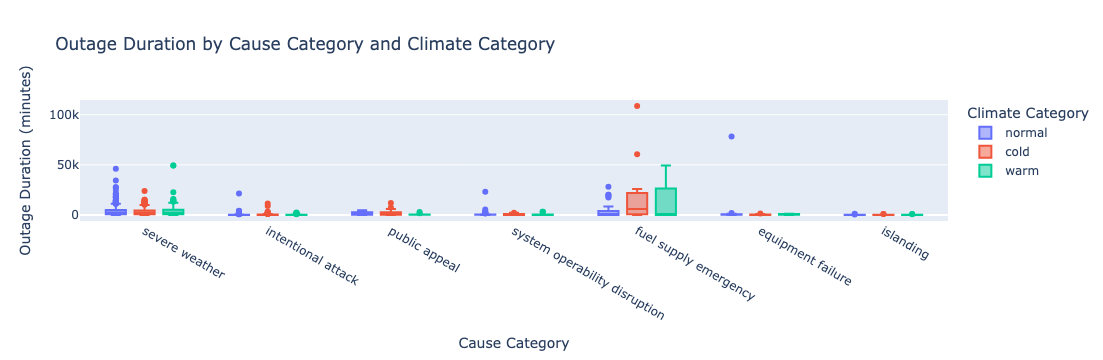

In [27]:
fig4 = px.box(
    df, 
    x="CAUSE.CATEGORY", 
    y="OUTAGE.DURATION", 
    color="CLIMATE.CATEGORY",  # Group by CLIMATE.CATEGORY
    title="Outage Duration by Cause Category and Climate Category",
    labels={"CAUSE.CATEGORY": "Cause Category", "OUTAGE.DURATION": "Outage Duration (minutes)", "CLIMATE.CATEGORY": "Climate Category"}
)

# Show the plot
fig4.show()
fig4.write_html('fig4.html', include_plotlyjs='cdn')

### Analysis 5) Cause Category and Cause Category Detail vs Outage Duration

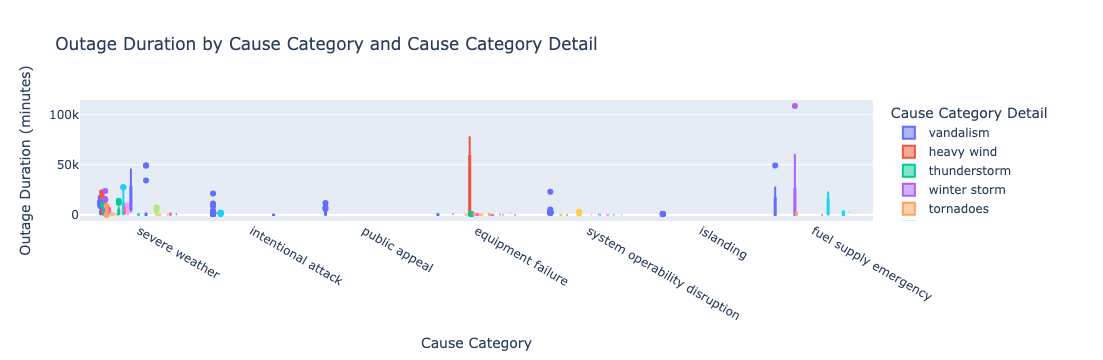

In [28]:
# Create a box plot to visualize the distribution of OUTAGE.DURATION for different CAUSE.CATEGORY and CAUSE.CATEGORY.DETAIL
fig5 = px.box(
    df, 
    x="CAUSE.CATEGORY", 
    y="OUTAGE.DURATION", 
    color="CAUSE.CATEGORY.DETAIL",  # Group by CAUSE.CATEGORY.DETAIL
    title="Outage Duration by Cause Category and Cause Category Detail",
    labels={"CAUSE.CATEGORY": "Cause Category", "OUTAGE.DURATION": "Outage Duration (minutes)", "CAUSE.CATEGORY.DETAIL": "Cause Category Detail"}
)

# Show the plot
fig5.show()


## Step 4: Baseline Model

In [29]:
# Defining features and target variable
X = df[['CLIMATE.CATEGORY', 'ANOMALY.LEVEL', 'CAUSE.CATEGORY.DETAIL','TOTAL.CUSTOMERS', 'RES.CUST.PCT']]  # Features
y = df['OUTAGE.DURATION']  # Target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=398)

# Define preprocessing for numerical and categorical features
numeric_features = ['ANOMALY.LEVEL', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT']
categorical_features = [ 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY.DETAIL']

# Create the preprocessing pipeline for numeric and categorical columns
# Numeric: Fill missing values, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by imputing with mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Categorical: Fill missing values, then encode using OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoder for categorical data
])

# Combine both transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the final pipeline with preprocessing + RandomForestRegressor (you can use other models too)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing to the data
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Model training step
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
# Calculate the range of the target variable
target_range = y_train.max() - y_train.min()

# Compute the Normalized Mean Absolute Error (NMAE)
nmae = mae / target_range

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized MAE (NMAE): {nmae}")

# Optionally, you can use cross-validation to assess model generalization
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-cv_scores.mean()}")

/Users/davidlisbonne/Documents/UM/SuperDuperSenior/398practicalds/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Mean Absolute Error (MAE): 2377.7677433887143
Root Mean Squared Error (RMSE): 5304.156964962214
Normalized MAE (NMAE): 0.021884050540608307
Cross-validated MAE: 2749.709381667469


## Step 5: Final Model

In [30]:
units, df = import_data()
df = clean_impute(df)

In [31]:
def create_new_features(df):
    # Log-transforming the target feature to handle skewed distribution
    df['LOG_CUSTOMERS_AFFECTED'] = np.log1p(df['CUSTOMERS.AFFECTED'])
    
    # Creating a new feature: Residential Customers in Region
    df['RES.CUSTOMERS'] = df['POPULATION'] * df['RES.CUST.PCT'] / 100
    return df

# Load and preprocess data
df = create_new_features(df)  # Apply feature engineering
X = df.drop(columns=['OUTAGE.DURATION'])  # Feature set
y = df['OUTAGE.DURATION']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numeric_features = ['POPULATION', 'ANOMALY.LEVEL', 'RES.CUST.PCT', 'RES.CUSTOMERS', 'LOG_CUSTOMERS_AFFECTED']
categorical_features = ['U.S._STATE', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']

# For numerical features, we apply imputation (in case of missing values) and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# For categorical features, we apply imputation (in case of missing values) and encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model setup: RandomForestRegressor with GridSearchCV for hyperparameter tuning
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],   # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20],   # Maximum depth of the trees
    'regressor__min_samples_split': [2, 5],   # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 2]     # Minimum number of samples required at a leaf node
}

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Train the model
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Print best params
print(f"Best parameteres from grid search: {grid_search.best_params_}")

# Evaluate the model
y_pred = best_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) for Final Model: {mae}")

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-cv_scores.mean()}")

# Calculate NMAE
nmae = mae / (y.max() - y.min())
print(f"Normalized Mean Absolute Error (NMAE) for Final Model: {nmae}")

Best parameteres from grid search: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Mean Absolute Error (MAE) for Final Model: 2420.3930900091705
Root Mean Squared Error (RMSE): 5572.70499958706


/Users/davidlisbonne/Documents/UM/SuperDuperSenior/398practicalds/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Cross-validated MAE: 2749.709381667469
Normalized Mean Absolute Error (NMAE) for Final Model: 0.022276357670834402


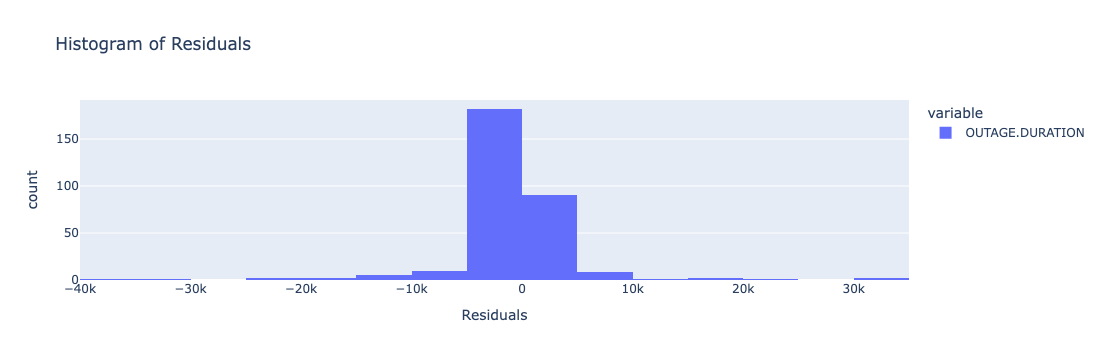

In [32]:
res = y_test - y_pred
fig = px.histogram(res, nbins=30, labels={'value': 'Residuals'}, title='Histogram of Residuals')
fig.show()
fig.write_html("finalmodelresiduals.html", include_plotlyjs='cdn')

In [33]:
hist_trace = go.Histogram(
    x=residuals,
    histnorm='density',  # Normalize the histogram to show density (similar to KDE)
    name='Residuals',
    nbinsx=30,  # You can adjust the number of bins here
    marker=dict(color='blue', opacity=0.7)
)

# Calculate the KDE using scipy.stats.gaussian_kde
kde = stats.gaussian_kde(residuals)
kde_x = np.linspace(min(residuals), max(residuals), 1000)
kde_y = kde(kde_x)

# Create a KDE line trace
kde_trace = go.Scatter(
    x=kde_x,
    y=kde_y,
    mode='lines',
    name='KDE',
    line=dict(color='red')
)

# Create the figure
fig = go.Figure(data=[hist_trace, kde_trace])

# Customize the layout
fig.update_layout(
    title='Distribution of Residuals',
    xaxis_title='Residuals',
    yaxis_title='Density',a
    showlegend=True
)

# Show the interactive plot
fig.show()

# Optionally, save the plot as an HTML file
fig.write_html("finalmodelresiduals.html", include_plotlyjs='cdn')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3718806345.py, line 30)